# Test Sphere attraction - 

### Interacting spheres, one expects Birkhoff, and I think that is what happens.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt



## Force calc
### get netX, nety, netz, then force between them is m1*m2/d^2, to get vectors, we use netx/dist to get x contribution, etc.

In [4]:
def calcForce2(d, s1x, s1y, s1z, s1m, s2x, s2y, s2z, s2m):
    netx =  d - s1x + s2x
    nety =  - s1y + s2y
    netz =  - s1z + s2z
    massF = s1m*s2m
    dist = np.sqrt(netx*netx + nety*nety + netz*netz)
    dC = dist*dist*dist # we need cubed, one to normalize the vector, the other two to do Newton's force
    fvec = np.array([massF*netx/dC, massF*nety/dC, massF*netz/dC])
    return fvec


def calcForce3(d, s1, s2, cellSize):
    netx =  d - s1[0] + s2[0]
    nety =  - s1[1] + s2[1]
    netz =  - s1[2] + s2[2]
    massF = s1[3]*s2[3]
    dist = np.sqrt(netx*netx + nety*nety + netz*netz)
    if dist < cellSize:
        return [0, 0, 0] #hack to not explode - ignore close points 
    dC = dist*dist*dist # we need cubed, one to normalize the vector, the other two to do Newton's force
    fvec = np.array([massF*netx/dC, massF*nety/dC, massF*netz/dC])
    return fvec

centre of mass 1: -1.1102230246251565e-16 -1.734723475976807e-17 -1.734723475976807e-17
centre of mass 2: -1.1102230246251565e-16 -1.734723475976807e-17 -1.734723475976807e-17
total mass 1: 1.9444444444444686
total mass 2: 1.9444444444444686
force distances: 300
forces per distance: 3
totalForce0: 3.064666845980168e-06
totalForce40: 0.8888969673107556


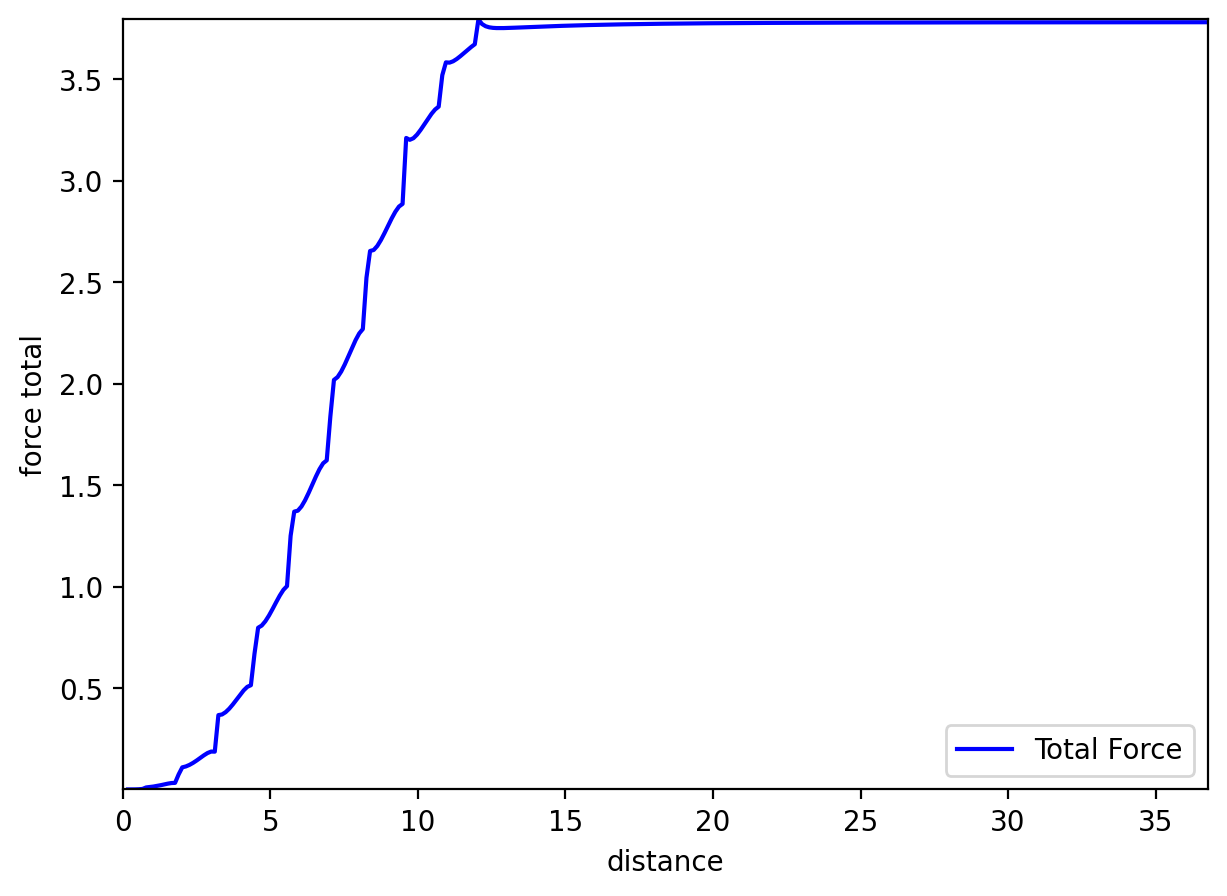

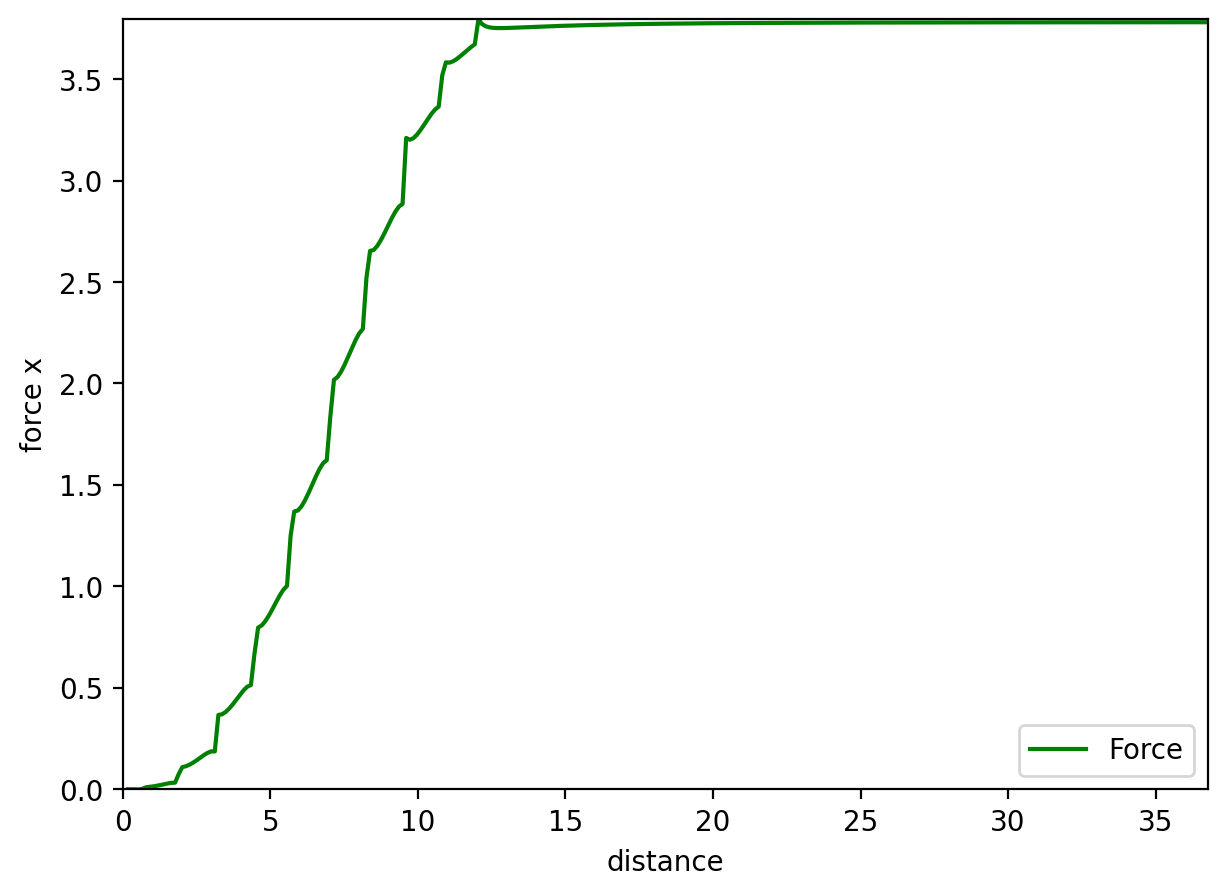

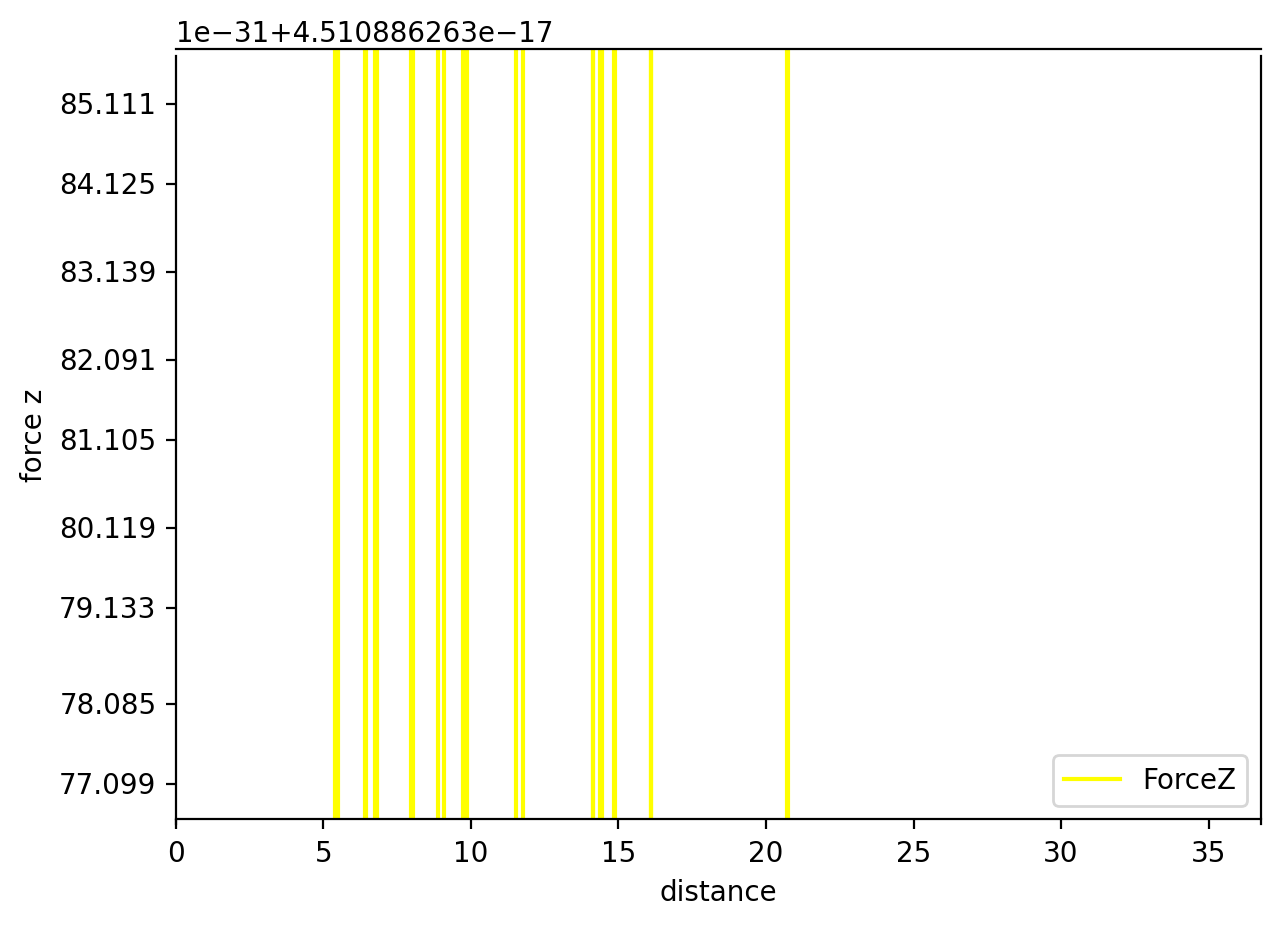

In [7]:


# idea - make two spheres, each with points that vary in mass with radius
# mass points are on non interecting planes of z 
# masses are held apart in x direction, moved together.
# both spheres have same number of points, just masses of each point varies 
# points in an XY plane are laid out in grid, with no points at r > r of sphere 
# (keeping in mind where each sphere has an origin at: 0 0 0 

rS1 = 7 # size of spheres
rS2 = 7 # size of spheres
volS1 = (4/3*np.pi*rS1*rS1*rS1)
volS2 = (4/3*np.pi*rS2*rS2*rS2)
numPoints = 15 # (2*numPoints)**3 points in the sphere use even numbers only so as to not get an infinite mass density...
m1 = 5
m2 = 5
cellSize1 = rS1/(2*numPoints)
cellSize2 = rS2/(2*numPoints)
# keep min dist and max dist odd weird numbers so points dont hit each other
minDist = 0.1753456456
maxDist = 36.774564569923
numDistPoints = 300

# mass function
# mass density in my model is slightly altered from the one in the Katz paper.
# start with equation 3, take derivative, then get '
# https://www.wolframalpha.com/input?i=derivative+of+M+-+M%2F%281+%2B+2x%2FM%29+
# then divide by area of a sphere to get my mass density. 
# https://www.wolframalpha.com/input?i=%282M%5E2%2F%28M+%2B+2x%29%5E2%29%2F%284*pi*x%5E2%29
# then we have
# total mass is m, total radius is rS, so each particle we have represents 1/(4/3pirS^3) worth of volume. 
# we take the mass density (say a constant or by formula) and mult by the volume to get the mass of each particle.

def massOfPointConstantDensity(r, m, volS):
    volPerPoint = volS/(numPoints*numPoints*numPoints)
    return m/volS*volPerPoint # constant density, 

# return mass density at r * volperpoint
def massOfPointLocalEnergy(r, m, volS):
    volPerPoint = volS/(numPoints*numPoints*numPoints)
    return m*m/(2*np.pi*r*r*(m + 2*r)*(m + 2*r))*volPerPoint



s1x = []
s1y = []
s1z = []
s1m = []
s1 = []

s2x = []
s2y = []
s2z = []
s2m = []
s2 = []

com1X = 0;
com1Y = 0;
com1Z = 0;
com2X = 0;
com2Y = 0;
com2Z = 0;
totalMass1 = 0
totalMass2 = 0
for x in np.linspace(-rS1, rS1, numPoints):
    for y in np.linspace(-rS1, rS1, numPoints):
        for z in np.linspace(-rS1, rS1, numPoints):
            r = np.sqrt(x*x + y*y + z*z)
            if r < rS1:
                #add a point to each
                # mass 
                m = massOfPointConstantDensity(r, m1, volS1)
                totalMass1 += m
                s1.append([x,y,z,m])
                s1x.append(x)
                s1y.append(y)
                s1z.append(z)
                s1m.append(m)
                com1X += m*x
                com1Y += m*y
                com1Z += m*z
                
for x in np.linspace(-rS2, rS2, numPoints):
    for y in np.linspace(-rS2, rS2, numPoints):
        for z in np.linspace(-rS2, rS2, numPoints):
            r = np.sqrt(x*x + y*y + z*z)
            if r < rS2:
                #add a point to each
                # mass                 
                m = massOfPointConstantDensity(r, m2, volS2)
                totalMass2 += m
                s2.append([x,y,z,m])
                s2x.append(x)
                s2y.append(y)
                s2z.append(z)
                s2m.append(m)
                com2X += m*x
                com2Y += m*y
                com2Z += m*z


# make our calcFunc return all the forces in an array
calcForceVec = np.frompyfunc(calcForce2, 9, 1)

print('centre of mass 1:',com1X, com1Y, com1Y)
print('centre of mass 2:',com2X, com2Y, com2Y)
print('total mass 1:',totalMass1)
print('total mass 2:',totalMass2)

# now we have our points in two numpy arrays, 
# for each point, we want to figure out the forces and add them all up.

forces = []
distances = np.linspace(minDist, maxDist, numDistPoints)
cellSize = 2*max(cellSize1, cellSize2)
for d in distances:
    dees = np.full(len(s1), d)
    forcesOnS1 = []
    for p1 in s1:
        forcesOnP1 = []
        for p2 in s2:
            forcesOnP1.append(calcForce3(d, p1, p2, cellSize))
        # Sum along columns (axis=0) - get total x, y, z forces, which 
        sumP1 = np.sum(forcesOnP1, axis=0) 
        forcesOnS1.append(sumP1)
    forces.append(np.sum(forcesOnS1, axis=0))


# forces = []
# distances = np.linspace(minDist, maxDist, numDistPoints)
# for d in distances:
#     dees = np.full(len(s1x), d)
#     forces.append(calcForceVec(dees, s1x, s1y, s1z, s1m, s2x, s2y, s2z, s2m))

print('force distances:',len(forces))
print('forces per distance:',len(forces[0]))
#print('force:',np.sum(forces[34][0]))

xForce = []
yForce = []
zForce = []
totalForce = []
maxForce = 0
minForce = 1e99
maxForceX = 0
minForceX = 1e99
maxForceZ = 0
minForceZ = 1e99
for xyzNet, d in zip(forces, distances):
    d2 = d*d
    dM = d2 # set to d2 to see errors from r^2, set dM to 1 to see actual r^2 graph
    #dM = 1
    # Sum along columns (axis=0) - get total x, y, z forces, which 
    # xyzNet = np.sum(fV, axis=0) 
    xT = xyzNet[0]*dM
    yT = xyzNet[1]*dM
    zT = xyzNet[2]*dM
    tF = np.sqrt(xT*xT + yT*yT + zT*zT)
    totalForce.append(tF)
    xForce.append(xT)
    yForce.append(yT)
    zForce.append(zT)
    maxForce = max(maxForce, tF)
    minForce = min(minForce, tF)
    maxForceX = max(maxForceX, xT)
    minForceX = min(minForceX, xT)
    maxForceZ = max(maxForceZ, zT)
    minForceZ = min(minForceZ, zT)

if np.abs(minForce - maxForce)/maxForce < 0.001:
    minForce = 0.99999999999999*maxForce
    maxForce = 1.00000000000001*maxForce

if np.abs(minForceX - maxForceX)/maxForce < 0.001:
    minForceX = 0.99999999999999*maxForceX
    maxForceX = 1.00000000000001*maxForceX

if np.abs(minForceZ - maxForceZ)/maxForce < 0.001:
    minForceZ = 0.99999999999999*maxForceZ
    maxForceZ = 1.00000000000001*maxForceZ


print('totalForce0:',totalForce[0])
print('totalForce40:',totalForce[40])

fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(distances, totalForce, marker="none", color='blue', lw=1.5, label='Total Force')
plt.xlabel('distance');
plt.ylabel('force total');
plt.legend(loc='lower right')
plt.axis((0, maxDist, minForce, maxForce));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(distances, xForce, marker="none", color='green', lw=1.5, label='Force')
plt.xlabel('distance');
plt.ylabel('force x');
plt.legend(loc='lower right')
plt.axis((0, maxDist, minForceX, maxForceX));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(distances, yForce, marker="none", color='yellow', lw=1.5, label='ForceZ')
plt.xlabel('distance');
plt.ylabel('force z');
plt.legend(loc='lower right')
plt.axis((0, maxDist, minForceZ, maxForceZ));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()
